                                               tweets  len  \
0   @kristinesabillo Share this also to you po Mis...  140   
1   Covid Vaccine here I come.\n💉 https://t.co/D7V...   52   
2   Thank you, @QCGov! Got my vaccine today. Stay ...   53   
3   My arm hurts more now, after 3 days of my 2nd ...   82   
4   Vaccination roll out for seafarers.. \nday 2 u...   90   
..                                                ...  ...   
95  Fully vaccinated! ✌ 💯\n.\n.\n.\n.\n.\n.\n.\n#v...  106   
96  @AusAmbPH Thanks for all the support provided ...  130   
97  It's not about the hesitation anymore, it's al...   86   
98  Got my card with QR code at the back. I am hap...  136   
99  Our church pastor explained about the rumored ...  140   

                  date  sentiment  
0  2021-08-07 03:18:39         -1  
1  2021-08-07 03:16:49          0  
2  2021-08-07 02:56:47          1  
3  2021-08-07 02:37:27          1  
4  2021-08-07 02:25:28          0  
..                 ...        ...  
95 

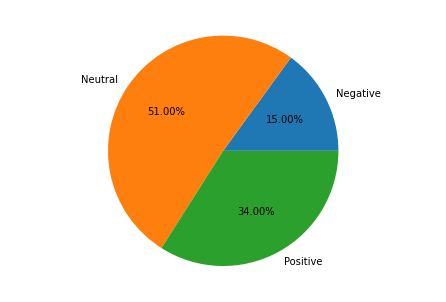

In [1]:
from tweepy import API
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

from textblob import TextBlob

import twitter_credentials
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

    def get_twitter_client_api(self):
        return self.twitter_client

class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))

        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1

    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])
        
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        
        return df

if __name__ == "__main__":
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    query = "vaccination OR #vaccination OR vaccine OR pfizer OR sinovac OR moderna OR astrazeneca OR COVID19 OR COVID-19"

    places = api.geo_search(query="PHILIPPINES",granularity="country")
    place_id = places[0].id

    tweets = api.search(q=query + "AND place:%s" % place_id, lang="en", count=100)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    print(df.head(100))
    
    a = np.array(df['sentiment'])
    unique, counts = np.unique(a, return_counts=True)

    sum = counts[0] + counts[1] + counts[2]
    
    status = ['Negative', 'Neutral', 'Positive']
    get_status = [counts[0]/sum, counts[1]/sum, counts[2]/sum]

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis('equal')
    ax.pie(get_status, labels=status, autopct='%1.2f%%')
    plt.show()